In [1]:
import numpy as np
import random
import pylab
from agent import *
from maze import *
from neural_network import *
from hrr import *
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Number of training cycles
episodes = 5000

# Hrr parameters
hrr_length = 2048
normalized = True

# How many steps to take before quiting
steps_till_quit = 30

# Maze parameters
size_of_maze = 10
non_obs_task_switch_rate = 50
num_non_obs_tasks = 1
num_obs_tasks = 1
# goals = [[0,2,1], [1,0,2],[2,1,0]]
# signals = ["red", "green", "blue"]
goals = [2]
signals = ["red"]

# random goal setting
# goals = np.stack([np.random.choice(range(size_of_maze), num_non_obs_tasks, replace=False) for _ in range(num_obs_tasks)])

# Arguments for neural network
input_size = hrr_length
output_size = 1
discount = 0.5
alpha = 0.1

# Reward for temporal difference learning
reward_bad = 0
reward_good = 1

# Expolration rate
e_soft = 0.02

# Threshold for non observable task switching
threshold = -0.2

# Print frequency
p_freq = 100

# Eligibility trace
eligibility = np.zeros(hrr_length)

# Eligibility trace rate
eli_lambda = 0.5

# atr = np.random.randint(0, num_non_obs_tasks + 1)
atr = 0
wm = "I"

# Neural network
weights = hrr(hrr_length, normalized)
bias = 0

In [3]:
agent = agent()
maze = maze(size_of_maze, non_obs_task_switch_rate, num_non_obs_tasks, num_obs_tasks, goals)
nn = NeuralNetwork(input_size, output_size, bias, discount, alpha, reward_good, reward_bad)
ltm = LTM("hrrs_1_" + str(hrr_length), hrr_length, normalized)

In [4]:
ltm.print()

redIn*state_7 [-0.00758803  0.0084037   0.01847788 ... -0.01801189  0.02999908
 -0.04485877]
non_obs_0*red*state_4 [-0.01565724 -0.00237761  0.01151839 ...  0.01815596  0.05920902
 -0.00105136]
red*state_9 [ 0.03527001 -0.01436423 -0.00659574 ...  0.00467669  0.01396588
 -0.00047054]
non_obs_0*redIn*state_1 [-0.00804808  0.03514687  0.01928786 ...  0.01548555  0.02246215
 -0.00203441]
blueIn*state_0 [-0.03560807  0.02140338  0.00601432 ... -0.02824409 -0.01330608
 -0.01644309]
blue*state_3 [-0.04503022  0.00679655 -0.03258675 ...  0.00449164  0.01044661
  0.01359409]
non_obs_0*redIn*rewardTkn [-0.0040881  -0.01060117 -0.00029526 ... -0.00210232  0.00258301
  0.0002102 ]
blueIn*state_1 [ 0.00224294  0.01633327 -0.01407195 ...  0.02696288  0.00434567
  0.0224394 ]
I*non_obs_0*state_7 [ 0.02299818  0.00807522 -0.05150077 ... -0.00313524 -0.00920842
  0.0056814 ]
blue*non_obs_0*state_3 [ 0.03101698 -0.00443707 -0.02190412 ...  0.03025695  0.00077842
 -0.01812219]
I*rewardTkn [-0.00966171 -

In [5]:
def move_policy(moves, wms, non_obs, rand_on):
    
    val = -9999
#     print(moves, wms, non_obs)
    
    # Random move
    if((np.random.random() < e_soft) and (rand_on == 1)):
        return np.random.choice(moves), random.choice(wms), random.choice(non_obs)
    
    # Loops through everything possibility
    for move in moves:
        for wm in wms:
            if(wm == "red" or wm == "blue" or wm == "green"):
                wm = wm + "In"
            temp = np.dot(weights, ltm.encode("state_" + str(move) + "*non_obs_" + str(non_obs[0]) + "*" + str(wm))) + bias
#             print(move, non_obs[0], wm, temp)
            if temp > val:
                val = temp
                s_move = move
                s_wm = wm
                    
    s_non_ob = non_obs[0]
    return s_move, s_wm, s_non_ob

def context_policy(atr):
    return (atr + 1)%num_non_obs_tasks

In [6]:
for x in range(episodes):
    
    # Starting state
    current = random.randint(0, size_of_maze - 1)
    
    # Signal for the maze run
    signal = np.random.choice(signals)
#     print(signal)
    
    # Maze progresses
#     non_obs, goal = maze.step_maze(signals.index(signal))
    non_obs = 0
    atr = 0
    goal = goals[0]
    
    # Reset trace
    eligibility *= 0.0
    
    wm = "I"
    
 #   print("Expected: Goal: " + str(goal) + " Signal: " + str(signal) + " Non_Observable: " + str(non_obs))
    
    for y in range(steps_till_quit):
        
        # Store info about previous state
        previous = current
        previous_state = ltm.encode(str(wm) + "*non_obs_" + str(atr) + "*state_" + str(previous))
        previous_value = np.dot(weights, previous_state) + bias
        
       # print("Started with: State: " + str(previous) + " State Value: " + str(previous_value) + " WM: " + str(wm) + " Atr: " + str(atr))
        
        eligibility *= eli_lambda
        
        left, right = agent.get_moves(previous, size_of_maze)
        move, wm, atr = move_policy([left, right], list(set([wm, signal])), [atr], 1)
        
        # Make the move
        current = move
        current_state = ltm.encode(str(wm) + "*non_obs_" + str(atr) + "*state_" + str(current))
        current_value = np.dot(weights, current_state) + bias
        
       # print("Moved: State: " + str(current) + " State Value: " + str(current_value) + " WM: " + str(wm) + " Atr: " + str(atr))
       
        # Goal reached
        if (current == goal):
            # Get temporal difference error and update weights of neural network
            goal_hrr = ltm.encode(str(wm) + "*non_obs_" + str(atr) + "*state_" + str(current) + "*rewardTkn")
            goal_value = np.dot(weights, goal_hrr) + bias
            
            error = (reward_bad + discount * goal_value - previous_value)
            eligibility = eligibility + previous_state
            weights = np.add(weights, (alpha * error * eligibility))
            
     #       print("In Goal: State Value: " + str(goal_value) + " WM: " + str(wm) + " Atr: " + str(atr))
     #       input("Press Enter to continue...")
            
            error = reward_good - goal_value
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * error * eligibility))
            
            break
        
        # Weight update for goal not found
        error = (reward_bad + discount * current_value) - previous_value
        eligibility = eligibility + previous_state
        if error < threshold:
                atr = context_policy(atr)
                eligibility = eligibility * 0.0
    #            print("Atr after policy: " + str(atr))
                
        weights = np.add(weights, (alpha * error * eligibility))
        
        signal = "I"
        
        
  #      input("Press Enter to continue...")
      
    if((x+1)%p_freq == 0):
        print("Episode" , x+1, "done")
#     if y >= steps_till_quit:
#         print("Failed and broke out")

Episode 100 done
Episode 200 done
Episode 300 done
Episode 400 done
Episode 500 done
Episode 600 done
Episode 700 done
Episode 800 done
Episode 900 done
Episode 1000 done
Episode 1100 done
Episode 1200 done
Episode 1300 done
Episode 1400 done
Episode 1500 done
Episode 1600 done
Episode 1700 done
Episode 1800 done
Episode 1900 done
Episode 2000 done
Episode 2100 done
Episode 2200 done
Episode 2300 done
Episode 2400 done
Episode 2500 done
Episode 2600 done
Episode 2700 done
Episode 2800 done
Episode 2900 done
Episode 3000 done
Episode 3100 done
Episode 3200 done
Episode 3300 done
Episode 3400 done
Episode 3500 done
Episode 3600 done
Episode 3700 done
Episode 3800 done
Episode 3900 done
Episode 4000 done
Episode 4100 done
Episode 4200 done
Episode 4300 done
Episode 4400 done
Episode 4500 done
Episode 4600 done
Episode 4700 done
Episode 4800 done
Episode 4900 done
Episode 5000 done


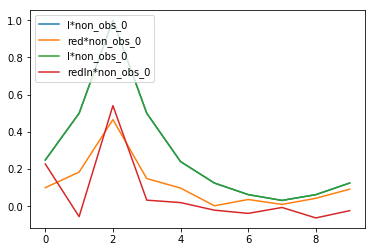

In [7]:
internal = [sig + "In" for sig in signals]
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
atr = 0
for extS in (["I"] + signals):
    lab = str(extS) + "*non_obs_" + str(atr)
    for state in range(size_of_maze):
        if state in goals:
            value[state] = np.dot(weights, ltm.encode(lab + "*state_" + str(state) + "*rewardTkn")) + bias
        else:
            value[state] = np.dot(weights, ltm.encode(lab + "*state_" + str(state))) + bias
    plt.plot(position, value, label=lab)
value = np.zeros(size_of_maze)
for intS in (["I"] + internal):
    lab = str(intS) + "*non_obs_" + str(atr)
    for state in range(size_of_maze):
        if state in goals:
            value[state] = np.dot(weights, ltm.encode(lab + "*state_" + str(state) + "*rewardTkn")) + bias
        else:
            value[state] = np.dot(weights, ltm.encode(lab + "*state_" + str(state))) + bias
    plt.plot(position, value, label=lab)
pylab.legend(loc='upper left')

In [8]:
ltm.print()

redIn*state_7 [-0.00758803  0.0084037   0.01847788 ... -0.01801189  0.02999908
 -0.04485877]
non_obs_0*red*state_4 [-0.01565724 -0.00237761  0.01151839 ...  0.01815596  0.05920902
 -0.00105136]
red*rewardTkn*state_2 [ 0.02467241 -0.0233319   0.0015848  ... -0.01873324  0.00474758
  0.00807867]
red*state_9 [ 0.03527001 -0.01436423 -0.00659574 ...  0.00467669  0.01396588
 -0.00047054]
red*state_2 [ 0.03308609 -0.00086705 -0.00409811 ... -0.02964591  0.01894681
 -0.0219796 ]
non_obs_0*redIn*state_1 [-0.00804808  0.03514687  0.01928786 ...  0.01548555  0.02246215
 -0.00203441]
blueIn*state_0 [-0.03560807  0.02140338  0.00601432 ... -0.02824409 -0.01330608
 -0.01644309]
blue*state_3 [-0.04503022  0.00679655 -0.03258675 ...  0.00449164  0.01044661
  0.01359409]
non_obs_0*redIn*rewardTkn [-0.0040881  -0.01060117 -0.00029526 ... -0.00210232  0.00258301
  0.0002102 ]
blueIn*state_1 [ 0.00224294  0.01633327 -0.01407195 ...  0.02696288  0.00434567
  0.0224394 ]
non_obs_0*red*state_1 [ 0.01709682 

In [9]:
ltm.clean()
del ltm, agent, maze, nn